<a href="https://colab.research.google.com/github/martinloretzzz/vector-index-layer/blob/main/GPTVectorIndexOnOutEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.0 MB/s eta 0:00:00


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import faiss

In [3]:
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

input_text = "The quick brown fox"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

output = model.generate(
    input_ids,
    max_length=50,
    return_dict_in_generate=True,
    output_hidden_states=True,
    output_scores=True,
    output_logits=True
)

gen_tokens = output.sequences

gen_text = tokenizer.batch_decode(gen_tokens)[0]
print(gen_text)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


The quick brown foxes are a great way to get a little bit of a kick out of your dog.

The quick brown foxes are a great way to get a little bit of a kick out of your dog. The quick brown fox


In [120]:
pos = 6

hidden = output.hidden_states
logits = output.logits

last_hidden = hidden[pos][-1].squeeze(0)
last_logits = logits[pos]

print(len(hidden), len(logits), len(hidden[pos]))
print(last_hidden.shape)
print(last_logits.shape)

46 46 13
torch.Size([1, 768])
torch.Size([1, 50257])


In [122]:
k = 50

topk_values, topk_indices = torch.topk(F.softmax(last_logits, dim=-1), k)

# print(torch.topk(F.softmax(torch.topk(logits[pos], 50)[0]), k)[0])

print(topk_values)
print(topk_indices)

tensor([[0.1144, 0.0270, 0.0261, 0.0240, 0.0220, 0.0218, 0.0163, 0.0146, 0.0145,
         0.0145, 0.0118, 0.0114, 0.0100, 0.0096, 0.0085, 0.0084, 0.0083, 0.0079,
         0.0079, 0.0077, 0.0077, 0.0070, 0.0069, 0.0066, 0.0065, 0.0059, 0.0056,
         0.0055, 0.0055, 0.0052, 0.0050, 0.0049, 0.0047, 0.0045, 0.0044, 0.0042,
         0.0041, 0.0041, 0.0041, 0.0040, 0.0040, 0.0038, 0.0038, 0.0038, 0.0037,
         0.0036, 0.0036, 0.0036, 0.0035, 0.0034]])
tensor([[  651,  1394,   905, 10400,   787,  4929,   923,   751,  8006,   766,
          1494,  1064,   423,  2193,  2222,  1011,  4545,  3613,  4729,  1037,
          1577,  2952,  1332,  4483,  3368,  3745,  1234,  1949,  1805,   467,
           779,  6654,   804,  4829,  4341,  2883, 19437,  5298,   886, 20528,
          2620,  2251,  1826,  7808,  8335,   711,  2245, 14947,  4512,  5911]])


In [123]:
in_emb = model.transformer.wte.weight.clone().detach()
in_emb.shape

torch.Size([50257, 768])

In [124]:
c_logits = last_hidden @ in_emb.T
print("HF:", last_logits)
print("EB:", c_logits)

HF: tensor([[-137.8715, -139.6316, -144.6972,  ..., -146.0522, -146.3333,
         -140.7632]])
EB: tensor([[-137.8715, -139.6316, -144.6972,  ..., -146.0522, -146.3333,
         -140.7632]])


In [125]:
in_emb_f = in_emb.clone().detach().numpy()
in_emb_f
vector_dimension = in_emb_f.shape[1]

In [126]:
faiss.normalize_L2(in_emb_f)
index = faiss.IndexFlatIP(vector_dimension)
index.add(in_emb_f)

In [127]:
q = last_hidden.clone().numpy()
faiss.normalize_L2(q)

distances_np, indices_np = index.search(q, k=5000)
distances, indices = torch.from_numpy(distances_np), torch.from_numpy(indices_np)

In [128]:
emb_w = in_emb[indices.squeeze(0)]
emb_w.shape

torch.Size([5000, 768])

In [129]:
out = last_hidden @ emb_w.T
# out = F.softmax(out, dim=-1)
print(out.shape)
out

torch.Size([1, 5000])


tensor([[-151.7190, -151.0921, -154.1506,  ..., -144.0900, -145.3496,
         -153.6795]])

In [130]:
indices.shape

torch.Size([1, 5000])

In [131]:
out_values, out_indices = torch.topk(out, k)
print(out_values, out_indices)
print(indices.squeeze(0)[out_indices])

tensor([[-131.8071, -132.7940, -132.7980, -132.8278, -132.8514, -133.4318,
         -133.7348, -133.8592, -133.8946, -134.2104, -134.2226, -134.3111,
         -134.3525, -134.4565, -134.5937, -134.7094, -134.7148, -134.7857,
         -134.8823, -134.9028, -134.9651, -135.1051, -135.1144, -135.1291,
         -135.1340, -135.1647, -135.2754, -135.3156, -135.3339, -135.3864,
         -135.3866, -135.3983, -135.5182, -135.6168, -135.6566, -135.6669,
         -135.7089, -135.7216, -135.7882, -135.8751, -135.9088, -135.9392,
         -135.9542, -136.0022, -136.1300, -136.1597, -136.1742, -136.1774,
         -136.1829, -136.2095]]) tensor([[4714, 3170, 4445, 4335, 1634, 4494, 3758, 3441, 2153, 3484, 2450, 2670,
         4367, 4045, 1841, 4649, 3741, 4434, 4512, 4708, 2600, 1808,  561, 2392,
         4623, 4726, 3853, 2805, 4975, 3015, 1923, 3349, 4243, 4789, 4989, 3146,
         2174, 4371, 4834,  707, 4709, 4762, 4010, 4616, 2325, 2388, 4309, 3081,
         4255, 4988]])
tensor([[34298, 2748

In [132]:
torch.topk(c_logits, k)

torch.return_types.topk(
values=tensor([[-127.7823, -129.2252, -129.2598, -129.3449, -129.4318, -129.4405,
         -129.7332, -129.8380, -129.8471, -129.8475, -130.0565, -130.0877,
         -130.2199, -130.2641, -130.3804, -130.3933, -130.4101, -130.4501,
         -130.4596, -130.4787, -130.4790, -130.5811, -130.5951, -130.6335,
         -130.6503, -130.7422, -130.8038, -130.8116, -130.8119, -130.8795,
         -130.9045, -130.9355, -130.9832, -131.0176, -131.0489, -131.0860,
         -131.1031, -131.1094, -131.1153, -131.1267, -131.1362, -131.1743,
         -131.1854, -131.1877, -131.2218, -131.2353, -131.2375, -131.2424,
         -131.2632, -131.2851]]),
indices=tensor([[  651,  1394,   905, 10400,   787,  4929,   923,   751,  8006,   766,
          1494,  1064,   423,  2193,  2222,  1011,  4545,  3613,  4729,  1037,
          1577,  2952,  1332,  4483,  3368,  3745,  1234,  1949,  1805,   467,
           779,  6654,   804,  4829,  4341,  2883, 19437,  5298,   886, 20528,
          

In [133]:
# print(indices)
print(topk_indices)

tensor([[  651,  1394,   905, 10400,   787,  4929,   923,   751,  8006,   766,
          1494,  1064,   423,  2193,  2222,  1011,  4545,  3613,  4729,  1037,
          1577,  2952,  1332,  4483,  3368,  3745,  1234,  1949,  1805,   467,
           779,  6654,   804,  4829,  4341,  2883, 19437,  5298,   886, 20528,
          2620,  2251,  1826,  7808,  8335,   711,  2245, 14947,  4512,  5911]])


In [134]:
def get_common(indices, ref_indices):
    return [i for i in ref_indices.tolist()[0:j] if i in indices.tolist()]


for j in [10, 20, 50]:
    common_indices = get_common(indices.squeeze(0), topk_indices.squeeze(0))
    print(f"{len(common_indices)}/{j} ({len(common_indices)/j:0.2f}): {common_indices}")

0/10 (0.00): []
0/20 (0.00): []
0/50 (0.00): []


## Clutering

In [135]:
x = in_emb.clone().numpy()

ncentroids = 2048
niter = 20
d = x.shape[1]

ncentroids: 2048
nsearch: 32


In [136]:
from sklearn.cluster import BisectingKMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Inner product distance
bkmeans = BisectingKMeans(n_clusters=ncentroids, random_state=42)
labels = torch.from_numpy(bkmeans.fit_predict(x))
centroids = torch.from_numpy(bkmeans.cluster_centers_)

print(centroids.shape)

torch.Size([2048, 768])


In [137]:
max_cluster_size = 32
nsearch = 32

In [138]:
n_labels = []
n_centorids = []
unique_labels, counts = torch.unique(labels, return_counts=True)
cluster_count = dict(zip(unique_labels.tolist(), counts.tolist()))

new_clusters = {}
new_clusters_count = {}

for l in labels.tolist():
  if l not in new_clusters or new_clusters_count[l] >= max_cluster_size:
    new_cluster = len(n_centorids)
    n_centorids.append(centroids[l])
    new_clusters[l] = new_cluster
    new_clusters_count[l] = 0

  n_labels.append(new_clusters[l])
  new_clusters_count[l] += 1

n_labels = torch.tensor(n_labels, dtype=torch.int32)
n_centorids = torch.stack(n_centorids)

# TODO run kmeans inside cluster to get more specific centroids

In [139]:
print(torch.unique(n_labels, return_counts=True))
print(n_labels)
print(n_centorids.shape)

(tensor([   0,    1,    2,  ..., 2774, 2775, 2776], dtype=torch.int32), tensor([32, 30, 32,  ...,  1,  1,  1]))
tensor([   0,    0,    1,  ..., 2483, 2643, 2776], dtype=torch.int32)
torch.Size([2777, 768])


tensor([32, 32, 32,  ...,  1,  1,  1])


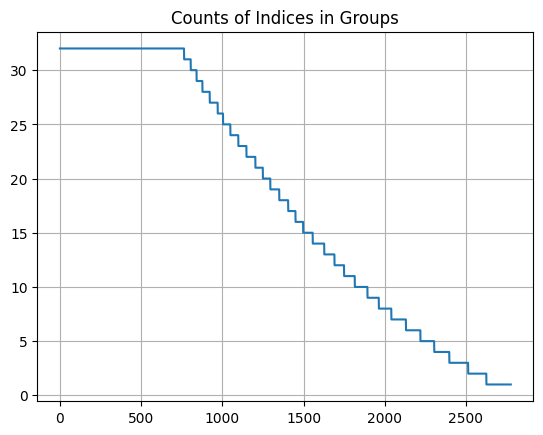

In [140]:
import matplotlib.pyplot as plt

counts = torch.unique(n_labels, return_counts=True)[1]
counts = torch.sort(counts, descending=True)[0]
print(counts)
plt.plot(range(len(counts)), counts)
plt.grid()
plt.title("Counts of Indices in Groups")
plt.show()

In [141]:
cluster_count = len(n_centorids)
cluster_arange = torch.arange(len(n_labels))
emb_from_centroid = torch.full((cluster_count, max_cluster_size), -1, dtype=torch.int32)
for cluster_id in range(cluster_count):
    cluster_data = cluster_arange[n_labels == cluster_id]
    emb_from_centroid[cluster_id, :len(cluster_data)] = cluster_data

print(emb_from_centroid.shape)
emb_from_centroid

torch.Size([2777, 32])


tensor([[    0,     1,     6,  ...,   563,   590,   601],
        [    2,    93,   140,  ..., 37941,    -1,    -1],
        [    3,     4,     7,  ...,  1544,  1870,  1875],
        ...,
        [50180,    -1,    -1,  ...,    -1,    -1,    -1],
        [50252,    -1,    -1,  ...,    -1,    -1,    -1],
        [50256,    -1,    -1,  ...,    -1,    -1,    -1]], dtype=torch.int32)

In [142]:
cent = last_hidden.squeeze(0) @ n_centorids.T
print(cent.shape)

centers_values, center_indices = torch.topk(cent, k=nsearch)
centers_values, center_indices

torch.Size([2777])


(tensor([-132.2869, -132.2869, -132.2869, -132.7649, -132.7649, -132.9182,
         -133.4594, -133.4594, -133.5175, -133.6947, -133.8382, -134.0378,
         -134.0378, -134.0586, -134.1568, -134.1568, -134.4701, -134.4701,
         -134.6079, -134.9297, -135.1464, -135.2577, -135.3654, -135.4310,
         -135.4948, -135.4948, -135.5474, -135.5952, -135.6522, -135.6554,
         -135.8982, -135.8982]),
 tensor([  84,  951,  504,  140,  899,  320,  759,  159,  354, 1106,  123, 1052,
          118,  124,  155, 1082, 1259,  391,  280, 1384,   45,  311,  431,   55,
          866, 2038, 1298,  535,  134, 1932,    5,   93]))

In [143]:
# handle out of bound
search_idx = emb_from_centroid[center_indices].view(-1)
search_idx.shape

torch.Size([1024])

In [144]:
emb_idx = in_emb[search_idx]
emb_idx.shape

torch.Size([1024, 768])

In [145]:
logits_idx = last_hidden.squeeze(0) @ emb_idx.T
logits_idx.shape

torch.Size([1024])

In [146]:
idx_values, idx_indices_raw = torch.topk(logits_idx, k)
idx_indices = search_idx[idx_indices_raw]
print(idx_values, idx_indices_raw)
print(idx_indices)

tensor([-127.7823, -129.2252, -129.2598, -129.3449, -129.4318, -129.4405,
        -129.7332, -129.8380, -129.8471, -130.0565, -130.0877, -130.2641,
        -130.3804, -130.3933, -130.4101, -130.4501, -130.4596, -130.4787,
        -130.4790, -130.5951, -130.7422, -130.8116, -130.8119, -130.8795,
        -130.9045, -130.9355, -130.9832, -131.0176, -131.0489, -131.0860,
        -131.1094, -131.1153, -131.1362, -131.1743, -131.1854, -131.1877,
        -131.2218, -131.2353, -131.2375, -131.2424, -131.2632, -131.2851,
        -131.2899, -131.2996, -131.3229, -131.3530, -131.4123, -131.4164,
        -131.4252, -131.4872]) tensor([  1,  13, 225, 273,   4, 124,  97,   2, 201, 102,   8,  22,  24,   5,
        260,  71, 550,   6,  15,  99, 114,  20,  18,   0,   3, 129,  96, 472,
        340, 331, 344, 224,  27,  25,  19, 770,  35, 385, 237, 834, 162,  93,
         80, 101, 107, 457,  82, 100, 513,  67])
tensor([  651,  1394,   905, 10400,   787,  4929,   923,   751,  8006,  1494,
         1064,  

In [172]:
exp_logits = torch.exp(last_logits.to(torch.float64).squeeze(0))

for j in [10, 20, 50]:
    common_indices = torch.tensor(get_common(idx_indices.squeeze(0), topk_indices.squeeze(0)))
    exp_logits_all = exp_logits[idx_indices.squeeze(0)[0:j]]

    exp_logits_common = exp_logits[common_indices]
    logits_percentage = exp_logits_common.sum() / exp_logits_all.sum()

    print(f"{len(common_indices)}/{j} ({len(common_indices)/j:0.2f}), logits: {logits_percentage:0.4f}")

9/10 (0.90), logits: 0.9598
18/20 (0.90), logits: 0.9613
42/50 (0.84), logits: 0.9492


In [169]:
exp_logits_common / exp_logits_all.sum()

tensor([0.2302, 0.0544, 0.0525, 0.0483, 0.0442, 0.0439, 0.0327, 0.0295, 0.0292,
        0.0237, 0.0230, 0.0192, 0.0171, 0.0169, 0.0166, 0.0160, 0.0158, 0.0155,
        0.0155, 0.0138, 0.0119, 0.0111, 0.0111, 0.0104, 0.0101, 0.0098, 0.0094,
        0.0091, 0.0088, 0.0085, 0.0083, 0.0082, 0.0080, 0.0077, 0.0077, 0.0076,
        0.0074, 0.0073, 0.0073, 0.0072, 0.0071, 0.0069], dtype=torch.float64)

In [148]:
"""
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, max_points_per_centroid=32, gpu=True, verbose=True)
fit = kmeans.train(x)
# D, I = kmeans.index.search(x, 1)
print(fit)
centroids = kmeans.centroids
print(centroids.shape)
"""

'\nkmeans = faiss.Kmeans(d, ncentroids, niter=niter, max_points_per_centroid=32, gpu=True, verbose=True)\nfit = kmeans.train(x)\n# D, I = kmeans.index.search(x, 1)\nprint(fit)\ncentroids = kmeans.centroids\nprint(centroids.shape)\n'